In [1]:
import pandas as pd
import numpy as np

#visualsation
import matplotlib.pyplot as plt

#dividing into train/test
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#model building
from sklearn.linear_model import LinearRegression

#model evaluation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


import joblib


from sklearn.pipeline import Pipeline


#feature engineering + features selection
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_regression

from sklearn.base import BaseEstimator, TransformerMixin

#cross validation
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict

In [2]:
 #defining feature names
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

In [3]:
train = pd.read_csv('../backend/CMAPSSData/train_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
test = pd.read_csv('../backend/CMAPSSData/test_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
rul = pd.read_csv('../backend/CMAPSSDATA/RUL_FD001.txt',sep='\s+',header=None,index_col=False,names=['RUL'])

In [4]:
def add_RUL_column(df):
    
    #get total number of cycles for each unit
    train_grouped_by_unit = df.groupby(by='unit_number') 
    max_time_cycles = train_grouped_by_unit['time_cycles'].max() 
    
    #merge the max cycle back into original frame
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    
    #calculate remaining useful life for each row
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    
    #drop max cycle as it's no longer needed
    merged = merged.drop("max_time_cycle", axis=1) 
    return merged

In [5]:
train = add_RUL_column(train)

In [6]:
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
i=1
for x in dict_list :
    Sensor_dictionary['s_'+str(i)]=x
    i+=1
Sensor_dictionary

{'s_1': '(Fan inlet temperature) (◦R)',
 's_2': '(LPC outlet temperature) (◦R)',
 's_3': '(HPC outlet temperature) (◦R)',
 's_4': '(LPT outlet temperature) (◦R)',
 's_5': '(Fan inlet Pressure) (psia)',
 's_6': '(bypass-duct pressure) (psia)',
 's_7': '(HPC outlet pressure) (psia)',
 's_8': '(Physical fan speed) (rpm)',
 's_9': '(Physical core speed) (rpm)',
 's_10': '(Engine pressure ratio(P50/P2)',
 's_11': '(HPC outlet Static pressure) (psia)',
 's_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's_13': '(Corrected fan speed) (rpm)',
 's_14': '(Corrected core speed) (rpm)',
 's_15': '(Bypass Ratio) ',
 's_16': '(Burner fuel-air ratio)',
 's_17': '(Bleed Enthalpy)',
 's_18': '(Required fan speed)',
 's_19': '(Required fan conversion speed)',
 's_20': '(High-pressure turbines Cool air flow)',
 's_21': '(Low-pressure turbines Cool air flow)'}

<h2> Understanding the dataset </h2>

In [7]:
train

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


In [8]:
 #shape - rows, columns
print('shape of train:', train.shape)
print('shape of valid:', test.shape)
print('total observations: ' , len(test) + len(train))
print('Percentage of the validation dataset : ',len(test)/(len(test)+len(train)))

shape of train: (20631, 27)
shape of valid: (13096, 26)
total observations:  33727
Percentage of the validation dataset :  0.3882942449669404


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20631 entries, 0 to 20630
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   unit_number  20631 non-null  int64  
 1   time_cycles  20631 non-null  int64  
 2   setting_1    20631 non-null  float64
 3   setting_2    20631 non-null  float64
 4   setting_3    20631 non-null  float64
 5   s_1          20631 non-null  float64
 6   s_2          20631 non-null  float64
 7   s_3          20631 non-null  float64
 8   s_4          20631 non-null  float64
 9   s_5          20631 non-null  float64
 10  s_6          20631 non-null  float64
 11  s_7          20631 non-null  float64
 12  s_8          20631 non-null  float64
 13  s_9          20631 non-null  float64
 14  s_10         20631 non-null  float64
 15  s_11         20631 non-null  float64
 16  s_12         20631 non-null  float64
 17  s_13         20631 non-null  float64
 18  s_14         20631 non-null  float64
 19  s_15     

In [10]:
train.nunique()

unit_number     100
time_cycles     362
setting_1       158
setting_2        13
setting_3         1
s_1               1
s_2             310
s_3            3012
s_4            4051
s_5               1
s_6               2
s_7             513
s_8              53
s_9            6403
s_10              1
s_11            159
s_12            427
s_13             56
s_14           6078
s_15           1918
s_16              1
s_17             13
s_18              1
s_19              1
s_20            120
s_21           4745
RUL             362
dtype: int64

In [11]:
train.loc[:,['unit_number','time_cycles']].describe()

,unit_number,time_cycles
count,20631.000000,20631.000000
mean,51.506568,108.807862
std,29.227633,68.880990
min,1.000000,1.000000
25%,26.000000,52.000000
50%,52.000000,104.000000
75%,77.000000,156.000000
max,100.000000,362.000000


In [12]:
train.loc[:,['setting_1', 'setting_2', 'setting_3']].describe()

,setting_1,setting_2,setting_3
count,20631.000000,20631.000000,20631.0
mean,-0.000009,0.000002,100.0
std,0.002187,0.000293,0.0
min,-0.008700,-0.000600,100.0
25%,-0.001500,-0.000200,100.0
50%,0.000000,0.000000,100.0
75%,0.001500,0.000300,100.0
max,0.008700,0.000600,100.0


In [13]:
train.loc[:,'s_1':].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s_1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s_5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200
s_6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
s_7,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
s_8,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
s_9,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
s_10,20631.0,1.300000,4.660829e-13,1.3000,1.3000,1.3000,1.3000,1.3000


In [14]:
maxrul_u = train.groupby('unit_number').max().reset_index()
maxrul_u

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,192,0.0047,0.0005,100.0,518.67,644.21,1605.44,1432.52,14.62,...,2388.35,8140.58,8.5227,0.03,398,2388,100.0,39.18,23.4999,191
1,2,287,0.0076,0.0006,100.0,518.67,643.94,1610.10,1431.17,14.62,...,2388.26,8175.57,8.5377,0.03,398,2388,100.0,39.24,23.6005,286
2,3,179,0.0058,0.0005,100.0,518.67,643.93,1606.50,1438.51,14.62,...,2388.20,8255.34,8.5363,0.03,399,2388,100.0,39.23,23.5181,178
3,4,189,0.0059,0.0006,100.0,518.67,644.53,1612.11,1434.12,14.62,...,2388.17,8259.42,8.5462,0.03,399,2388,100.0,39.21,23.5074,188
4,5,269,0.0055,0.0005,100.0,518.67,644.02,1609.41,1434.59,14.62,...,2388.23,8215.19,8.5410,0.03,398,2388,100.0,39.29,23.5503,268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,336,0.0049,0.0005,100.0,518.67,644.20,1608.62,1432.65,14.62,...,2388.28,8146.04,8.5615,0.03,398,2388,100.0,39.18,23.5344,335
96,97,202,0.0050,0.0006,100.0,518.67,643.97,1610.66,1430.66,14.62,...,2388.17,8270.91,8.5596,0.03,400,2388,100.0,39.22,23.5181,201
97,98,156,0.0077,0.0004,100.0,518.67,644.39,1606.24,1432.16,14.62,...,2388.30,8156.01,8.5308,0.03,396,2388,100.0,39.30,23.5461,155
98,99,185,0.0059,0.0005,100.0,518.67,644.10,1616.91,1436.54,14.62,...,2388.33,8145.61,8.5592,0.03,397,2388,100.0,39.20,23.4986,184


In [15]:
drop_labels = index_names+setting_names
X_train=train.drop(columns=drop_labels).copy()
X_train, X_test, y_train, y_test=train_test_split(
    X_train.drop('RUL', axis=1), #predictor
    X_train['RUL'], #target
    test_size=0.3, #split
    random_state=0) #set seed for reproducibility

<h2>Building the pipeline </h2>

In [16]:
rev_constants = Pipeline([
    #removing constant values
    ('variance_threshold', VarianceThreshold()),
])

In [17]:
rev_constants.fit(train)

Pipeline(steps=[('variance_threshold', VarianceThreshold())])

In [18]:
train_transformed=rev_constants.transform(train)

In [19]:
print("Original data shape:", train.shape)
print("Transformed data shape:", train_transformed.shape)

# Get the mask of features retained
feature_mask = rev_constants.named_steps['variance_threshold'].get_support()

# Get the indices of removed features
removed_indices = [i for i, mask in enumerate(feature_mask) if not mask]

print("Indices of removed features:", removed_indices)

Original data shape: (20631, 27)
Transformed data shape: (20631, 20)
Indices of removed features: [4, 5, 9, 14, 20, 22, 23]


dropped: setting_3, s1, s_5, s_10, s_16, s_18, s_19

In [20]:
class RemoveCorrelatedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.65):
        self.threshold = threshold
        self.correlated_features = None

    def fit(self, X, y=None):
        correlation_matrix = np.corrcoef(X,y, rowvar=False)
        highly_correlated_mask = np.abs(correlation_matrix) > self.threshold
        upper_triangle_mask = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
        highly_correlated_mask = highly_correlated_mask & upper_triangle_mask
        correlated_pairs = np.where(highly_correlated_mask)
        self.correlated_features = set()
        for feature1, feature2 in zip(*correlated_pairs):
            if feature1 not in self.correlated_features and feature2 not in self.correlated_features:
                correlation1 = correlation_matrix[feature1, feature2]
                correlation2 = correlation_matrix[feature2, feature1]
                if correlation1 > correlation2:
                    self.correlated_features.add(feature2)
                else:
                    self.correlated_features.add(feature1)
        return self

    def transform(self, X):
        return np.delete(X, list(self.correlated_features), axis=1)

In [21]:
feature_selection = Pipeline([
    ('variance_threshold', VarianceThreshold()),
    ('remove_correlated', RemoveCorrelatedFeatures(threshold=0.85)),
    
])

In [22]:
feature_selection.fit(X_train, y_train)

Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('remove_correlated',
                 RemoveCorrelatedFeatures(threshold=0.85))])

In [23]:
X_processed = feature_selection.transform(X_train)

# Assuming 'X' is your feature matrix before applying the pipeline
print("Number of features before:", X_train.shape[1])
# Check the number of features after transformation
print("Number of features after:", X_processed.shape[1])

# Get the dropped feature names
dropped_feature_names = [X_train.columns[idx] for idx in feature_selection.named_steps['remove_correlated'].correlated_features]

# Print the dropped feature names
print("Dropped features:", dropped_feature_names)

Number of features before: 21
Number of features after: 14
Dropped features: ['s_7']


In [24]:
#Liinear Regression Model: 

class Linear_Regression() :
    def __init__( self, lr=0.01, iterations=150 ) :    
        self.lr = lr
        self.iterations = iterations     
    def fit( self, X, Y ) :
        self.l, self.p = X.shape
        # weight initializer
        self.W = np.zeros( self.p )
        self.b = 0
        self.X = X
        self.Y = Y
        # gradientlearning      
        for i in range( self.iterations ) :  
            self.weight_updater()
        return self
         
    def weight_updater( self ) :
        Y_pred = self.predict( self.X )  
        #  gradients  
        dW = - ( 2 * ( self.X.T ).dot( self.Y - Y_pred )  ) / self.l
        db = - 2 * np.sum( self.Y - Y_pred ) / self.l
        # new weights assigned
        self.b = self.b - self.lr * db
        self.W = self.W - self.lr * dW
        return self
          
    def predict( self, X ) :
          # Y_pr=X.W+b
        return X.dot( self.W ) + self.b

In [26]:
ML_pipeline = Pipeline([
    ('variance_threshold', VarianceThreshold()),
    ('remove_correlated', RemoveCorrelatedFeatures(threshold=0.85)),
    ('scaler', StandardScaler()),
    ('linear_regression', Linear_Regression()),
])


In [27]:
ML_pipeline.fit(X_train,y_train)

Pipeline(steps=[('variance_threshold', VarianceThreshold()),
                ('remove_correlated', RemoveCorrelatedFeatures(threshold=0.85)),
                ('scaler', StandardScaler()),
                ('linear_regression',
                 <__main__.Linear_Regression object at 0x12cde1ad0>)])

In [28]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_hat)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}, MAE:{}'.format(label, rmse, variance, mae))

In [29]:
# Predictions on training set
pred_train = ML_pipeline.predict(X_train)

# Evaluate rounded predictions on training set
evaluate(y_train, pred_train, label = "train")


# Predictions on test set
pred_test = ML_pipeline.predict(X_test)

# Evaluate rounded predictions on test set
evaluate(y_test, pred_test)


train set RMSE:45.11882339587088, R2:0.5741589265123439, MAE:33.777141306313055
test set RMSE:44.8388686652215, R2:0.5685722901714971, MAE:33.5612259626188


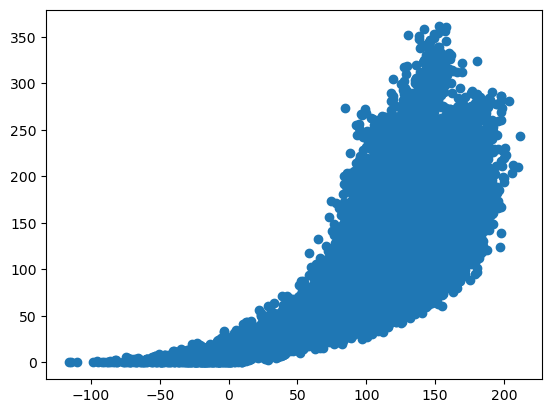

In [30]:
plt.scatter(pred_train, y_train)

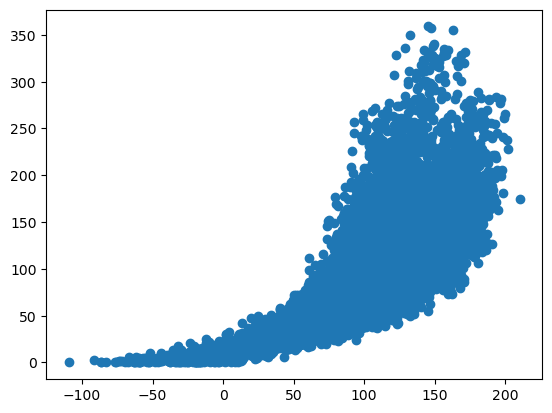

In [31]:
plt.scatter(pred_test, y_test)

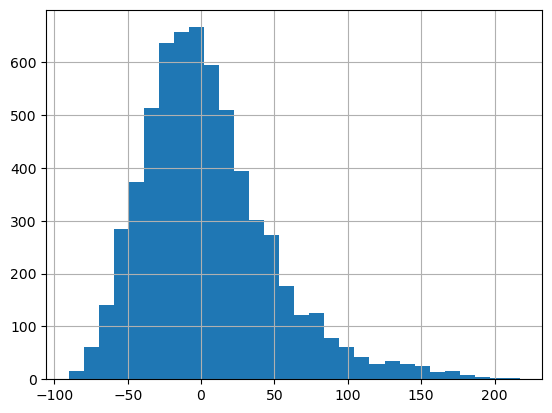

In [32]:
y_test.reset_index(drop=True, inplace=True)

preds = pd.Series(ML_pipeline.predict(X_test))

errors = y_test - preds
errors.hist(bins=30)
plt.show()

<h2> Cross Validation </h2>

In [34]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [35]:
# Perform cross-validation on the training set
cv_predictions_train = cross_val_predict(ML_pipeline, X_train, y_train, cv=kf)

# Evaluate cross-validated predictions on training set
evaluate(y_train, cv_predictions_train, label='cross-validation on training')

# Fit the pipeline to the entire training set
ML_pipeline.fit(X_train, y_train)

# Make predictions on the test set
test_predictions = ML_pipeline.predict(X_test)

# Evaluate the model on the test set
evaluate(y_test, test_predictions, label='test')


cross-validation on training set RMSE:45.14936969179341, R2:0.5735821264207914, MAE:33.80280322548654
test set RMSE:44.8388686652215, R2:0.5685722901714971, MAE:33.5612259626188


<h1> Scoring </h1>

In [36]:
X_valid = test.groupby('unit_number').last().reset_index().drop(columns=drop_labels)

In [37]:
new_pred = ML_pipeline.predict(X_valid)
evaluate(rul, new_pred, label = 'valid')

valid set RMSE:28.166340942074836, R2:0.5405890739722319, MAE:21.911620328350406


Text(0.5, 1.0, 'Evaluation of RUL Predictions using LR correlation')

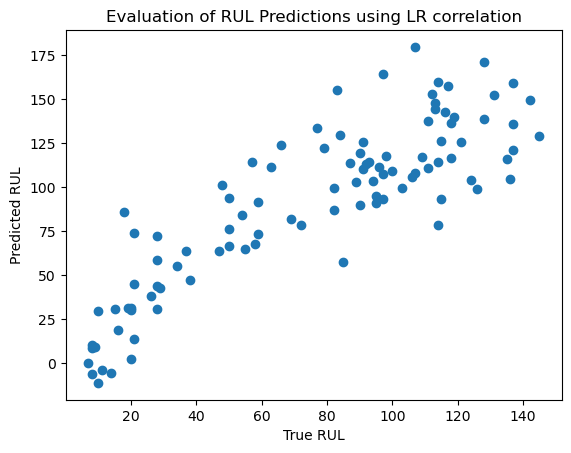

In [38]:
plt.scatter(rul, new_pred)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('Evaluation of RUL Predictions using LR correlation')

In [39]:
save_path = "../backend/"

# Fit the pipeline to the entire training set
ML_pipeline.fit(X_train, y_train)

# Serialize the trained model to a file in the specified location
joblib.dump(ML_pipeline, save_path + 'LR_correlation.pkl')

['../backend/LR_correlation.pkl']